In [ ]:
!git clone https://gitlab.com/lambda-hse/gans_coursera_public
%cd gans_coursera_public
from grading import Grader
parts = ['G92ae']
grader = Grader('Sli2Cga0QQWyL3aCpdu64Q', parts)
COURSERA_EMAIL, COURSERA_TOKEN = 'mvershov@edu.hse.ru', "QnmGOc1nn5wRtdoa" # PASTE YOUR COURSERA EMAIL AND ASSIGNMENT TOKEN HERE

Cloning into 'gans_coursera_public'...
remote: Enumerating objects: 88, done.
remote: Total 88 (delta 0), reused 0 (delta 0), pack-reused 88
Unpacking objects: 100% (88/88), done.
/content/gans_coursera_public


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"0B7EVK8r0v71pZjFTYXZWM3FlRnM"}) # Download Celeba dataset
downloaded.GetContentFile('img_align_celeba.zip') 
!unzip img_align_celeba.zip > /dev/null


# Data
CelebA [dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) will be used

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


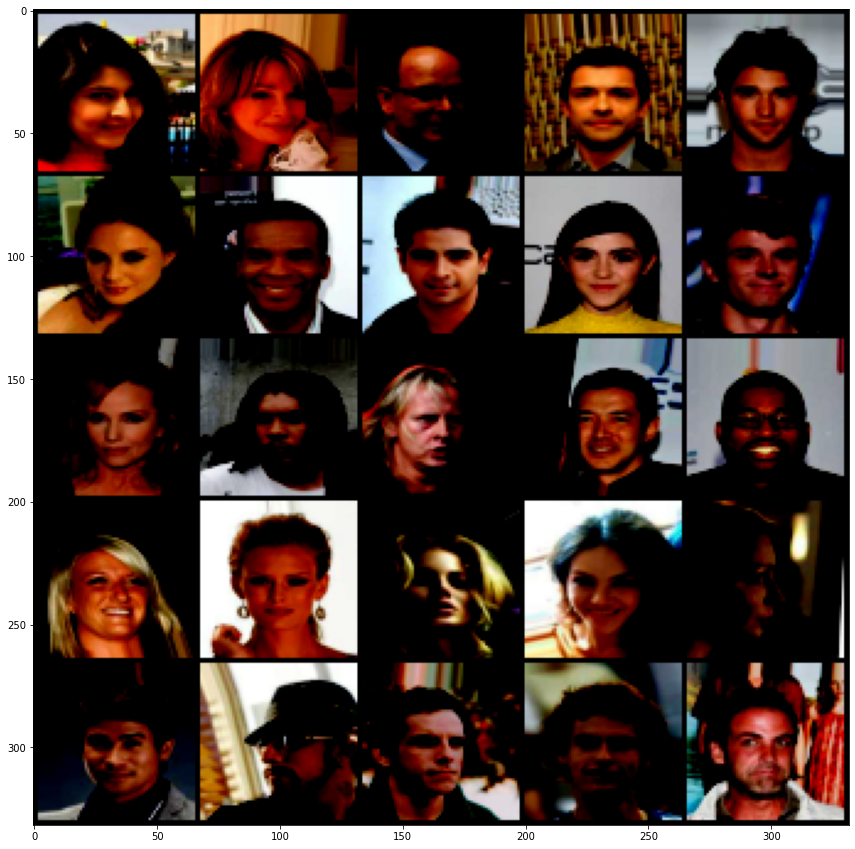

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.utils as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Optional
import PIL
import os

batch_size = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transforms = transforms.Compose([ # Compose combines a number of transforms into one operation
    transforms.Resize((64, 64)),
    transforms.ToTensor(), # PIL Image -> Tensor
    transforms.Normalize([0.5], [0.5])
])

# We can use torchvision package to get MNIST dataset

CELEBA_PATH = "./img_align_celeba/"

class CelebA(torch.utils.data.Dataset):
  def __init__(self, root_path:str, transform: Optional[Callable] = None):
    super().__init__()
    self.transform = transform
    self.root_path = root_path
    self.img_paths = os.listdir(root_path)

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, idx:int):
    img = PIL.Image.open(os.path.join(self.root_path, self.img_paths[idx]))
    if self.transform: img = self.transform(img)
    return img

    


full_dataset = CelebA(CELEBA_PATH, transform=transforms)

dataloader = torch.utils.data.DataLoader(dataset=full_dataset,
                                           batch_size=64,
                                           shuffle=True,
                                           drop_last=True)

from torchvision.utils import make_grid
plt.figure(figsize=(15,15))
plt.imshow(make_grid([full_dataset[i] for i in range(25)], nrow=5).permute(1,2,0))

# Variational Auto Encoder (VAE)

## Problem

Latent space is not completely covered by standard autoencoders (irregularity problem)

![](https://miro.medium.com/max/1000/1*83S0T8IEJyudR_I5rI9now@2x.png)

## Solution

Lets learn posterior distribution of z given x: $p(z|x)$ instead of pointwise estimation of z

## Problem 2

How to fit $p(z|x)$? Originally we can only make a suggestion about prior $p(z)$ (it can be $\mathcal{N}(0,1)$, for instance)

## Solution 

Lets approximate $p(z|x)$ with neural network $q_x(z)$:

![](https://miro.medium.com/max/700/1*j9goPhh0meH884uGL70Aqg@2x.png)

$q_x(z)$ can be fitted to $p(z|x)$ by KL-divergence minimization:

![](https://miro.medium.com/max/700/1*v56YF5KqZk35r85EZBZuAQ@2x.png)

In [ ]:
from torch.autograd import Variable

In [ ]:
# The code is taken from https://github.com/ku2482/vae.pytorch

class Encoder(nn.Module):
    def __init__(self, nc, nef, nz, isize, device):
        super(Encoder, self).__init__()

        # Device
        self.device = device

        # Encoder: (nc, isize, isize) -> (nef*8, isize//16, isize//16)
        self.encoder = nn.Sequential(
            nn.Conv2d(nc, nef, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef),

            nn.Conv2d(nef, nef*2, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*2),

            nn.Conv2d(nef*2, nef*4, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*4),

            nn.Conv2d(nef*4, nef*8, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(nef*8)
        ) # YOUR CODE HERE
        # Map the encoded feature map to the latent vector of mean, (log)variance
        out_size = isize // 16
        self.mean = nn.Linear(nef*8*out_size*out_size, nz) # YOUR CODE HERE
        self.logvar = nn.Linear(nef*8*out_size*out_size, nz) # YOUR CODE HERE

    @staticmethod
    def reparametrize(mu, logvar):
        ### return sample from normal distribution using reparametrization trick given MU and LOGVARiance
        ### hint 1: sample has the same shape and logvar and mu variables
        ### hint 2: logvar is diagonal
        std = logvar.mul(0.5).exp_()
        multi_norm = torch.FloatTensor(std.size()).normal_().to(device)
        multi_norm = Variable(multi_norm)
        return multi_norm.mul(std).add_(mu) # YOUR CODE HERE

    def forward(self, inputs):
        # Batch size
        batch_size = inputs.size(0)

        # Encoded feature map
        hidden = self.encoder(inputs)
        # Reshape
        hidden = hidden.view(batch_size, -1)


        # Calculate mean and (log)variance
        mean, logvar = self.mean(hidden), self.logvar(hidden) # YOUR CODE HERE
        # Sample
        latent_z = self.reparametrize(mean, logvar)

        return latent_z, mean, logvar

class Decoder(nn.Module):
    def __init__(self, nc, ndf, nz, isize):
        super(Decoder, self).__init__()

        # Map the latent vector to the feature map space
        self.ndf = ndf
        self.out_size = isize // 16
        self.decoder_dense = nn.Sequential(
            nn.Linear(nz, ndf*8*self.out_size*self.out_size),
            nn.ReLU(True)
        )
        self.decoder_conv = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*8, ndf*4, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf*4, 1.e-3),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*4, ndf*2, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf*2, 1.e-3),
        
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf*2, ndf, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ndf, 1.e-3),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(ndf, nc, 3, padding=1)
        ) # YOUR CODE HERE

    def forward(self, input):
        batch_size = input.size(0)
        hidden = self.decoder_dense(input).view(
            batch_size, self.ndf*8, self.out_size, self.out_size)
        output = self.decoder_conv(hidden) # YOUR CODE HERE 
        return output # reconstructed image

class VAE(nn.Module):
    def __init__(self, nc=3, ndf=32, nef=32, nz=100, isize=64, device=torch.device("cuda:0"), is_train=True):
        super(VAE, self).__init__()

        self.nz = nz
        self.isize=isize
        # Encoder
        self.encoder = Encoder(nc=nc, nef=nef, nz=nz, isize=isize, device=device) # YOUR CODE HERE
        # Decoder
        self.decoder = Decoder(nc=nc, ndf=ndf, nz=nz, isize=isize) # YOUR CODE HERE

        if is_train == False:
            for param in self.encoder.parameters():
                param.requires_grad = False
            for param in self.decoder.parameters():
                param.requires_grad = False

    def forward(self, x):
        latent_z, mean, logvar = self.encoder(x)
        rec_x = self.decoder(latent_z)
        return rec_x, mean, logvar
    
    def encode(self, x):
        latent_z, _, _ = self.encoder(x)
        return latent_z

    def decode(self, z):
        return self.decoder(z)

    @staticmethod
    def reparametrize(mu, logvar):
        ### return sample from normal distribution using reparametrization trick given MU and LOGVARiance
        ### hint 1: sample has the same shape and logvar and mu variables
        ### hint 2: logvar is diagonal
        eps = torch.randn(mu.shape, device=mu.device)
        z_sample = mu + torch.exp(0.5*logvar)*eps
        return z_sample # YOUR CODE HERE

    def sample(self, size):
        # generate random sample z from prior p(z) and pass through the decoder. It will be your new generated sample
        z = torch.randn((size, self.nz), device=self.encoder.device)
        samples = self.decoder(z)
        return samples # YOUR CODE HERE
    
    @property
    def device(self): return next(self.parameters()).device

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Fit VAE
Implement variational autoencoder (VAE)

**Hint 1**:
$$L = \int_zq(z)log(p(x|\Theta,z))dz - KL(q(z)||p(z))$$
**Hint 2**:

$$p(z)=\mathcal{N}(0,1)$$

$$q(z)=\mathcal{N}(\mu_1,\Sigma_1)$$

$\Sigma_1$ is diagonal!

$$\mathcal{D}[\mathcal{N}(\mu_0, \Sigma_0)||\mathcal{N}(\mu_1, \Sigma_1)] = \frac{1}{2}\big(tr(\Sigma_1^{-1}\Sigma_0)+(\mu_1-\mu_0)^T\Sigma_1^{-1}(\mu_1-\mu_0)-k+\log(\frac{\det\Sigma_1}{\det\Sigma_0})\big)$$
(k-dimensionality)


In [ ]:
import torch.nn.functional as F

crit = nn.MSELoss(reduction='sum')
def loss_function(recon_x, x, mu, logvar):
    batch_size = recon_x.shape[0]

    MSE = crit(x, recon_x) / batch_size # YOUR CODE HERE (reconstruction loss)
    KLD =  -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), 1) # KL between q(z) and p(z)
    KLD = KLD.mean()
    return MSE, KLD

log_interval=10
epochs=10


def train(pbar):
    model.train()
    train_mse, train_kld, train_loss = 0, 0, 0
    for batch_idx, data in enumerate(dataloader):
        #??? # YOUR CODE HERE
        optimizer.zero_grad()
        data = data.to(device)
        recon_batch, mu, logvar = model.forward(data) # YOUR CODE HERE
        mse_loss, kld_loss = loss_function(recon_batch, data, mu, logvar)
        loss = mse_loss + kld_loss
        #??? # YOUR CODE HERE
        loss.backward()
        optimizer.step()
        pbar.set_description(f"[KL: {kld_loss.item()/len(data) :.2f}] [MSE: {mse_loss.item()/len(data): .2f}]")
        pbar.update(1)
    
with tqdm(total=epochs*len(dataloader), desc=f"[KL: ?] [MSE: ?]") as pbar:
  for epoch in range(1, epochs + 1):
      train(pbar)
      with torch.no_grad():
          sample = model.sample(64).cpu()
          log_img = make_grid(sample)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


[KL: ?] [MSE: ?]:   0%|          | 0/31650 [00:00<?, ?it/s]

In [ ]:
torch.save(model.state_dict(), "10epochs_my_vae.pth")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


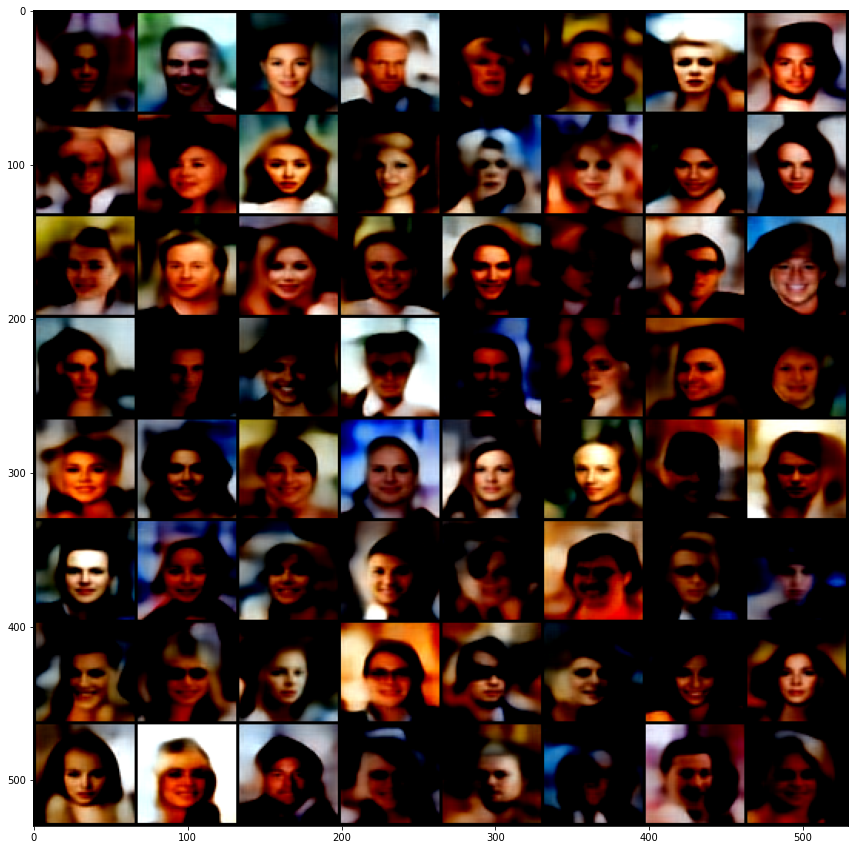

In [ ]:
#MY
plt.figure(figsize=(15,15))
plt.imshow(log_img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


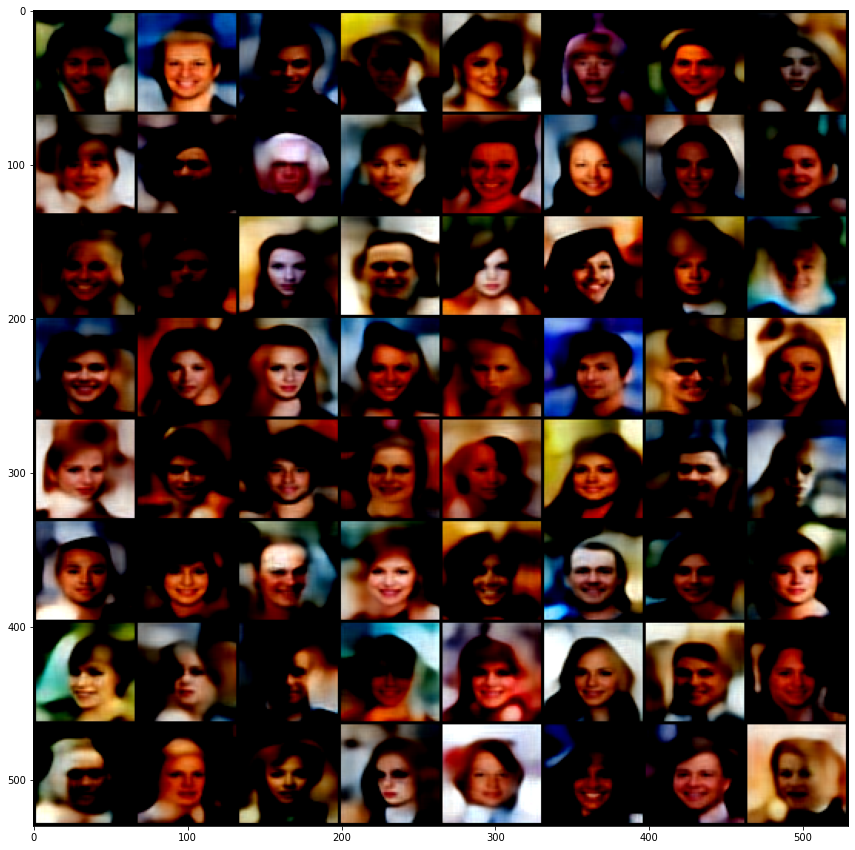

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(log_img.permute(1,2,0))

  Cloning https://github.com/S-aiueo32/lpips-pytorch.git to /tmp/pip-req-build-qz51q097
  Running command git clone -q https://github.com/S-aiueo32/lpips-pytorch.git /tmp/pip-req-build-qz51q097
  Running command git submodule update --init --recursive -q
  Created wheel for lpips-pytorch: filename=lpips_pytorch-latest-py3-none-any.whl size=4980 sha256=c577cdb230a5af722e84be4ac164c398977bcadcf0c6463cd4ce85cfd4e9f065
  Stored in directory: /tmp/pip-ephem-wheel-cache-tx6g2iv3/wheels/1e/cf/b5/31d11273e162675221f38043989d970cf7c7c8571d4e8d456d
Failed to build lpips-pytorch
    Running setup.py install for lpips-pytorch ... done
  DEPRECATION: lpips-pytorch was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Downloading: "https://raw.githubusercontent.com/richzhang/PerceptualSimilarity/master/lpips/weights/v0.1/alex.pth" to /root/.cache/torch/hub/checkpoints/alex.pth


  0%|          | 0.00/5.87k [00:00<?, ?B/s]

  0%|          | 0/3165 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


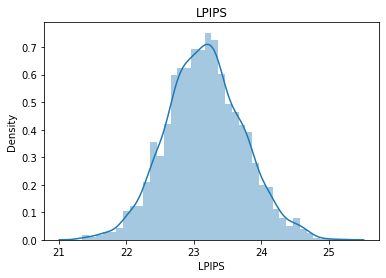

In [ ]:
# GRADED PART! DO NOT CHANGE!!!
!pip install git+https://github.com/S-aiueo32/lpips-pytorch.git

from lpips_pytorch import LPIPS, lpips
from tqdm.notebook import tqdm

# define as a criterion module (recommended)
criterion = LPIPS(
    net_type='alex',  # choose a network type from ['alex', 'squeeze', 'vgg']
    version='0.1'  # Currently, v0.1 is supported
)

dists = []
with torch.no_grad():
  for batch_idx, data in tqdm(enumerate(dataloader), total=len(dataloader)):
        batch_size = data.shape[0]
        sample = model.sample(batch_size).cpu()
        dist = criterion(sample, data).squeeze().item()
        dists.append(dist)
import seaborn as sns

plt.title('LPIPS')
plt.xlabel('LPIPS')
sns.distplot(dists)

In [ ]:
grader.set_answer(parts[0], np.mean(dists)) # Mean LPIPS must be less than 28
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


# Links
* simple explanation - [towardsds](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)

* ELBO inference - [link](https://chrisorm.github.io/VI-ELBO.html)